In [1]:
import copy
import math

In [2]:
graph_name = "graph_dijkstra"

graph = {}
with open(f"{graph_name}.txt", "r") as f:
    line = f.readline()
    while line:
        node_edges = line.split()
        node = node_edges[0]
        edges = node_edges[1:]
        # graph[node] = set(edges)
        graph[node] = edges
        line = f.readline()
graph

{'A': ['C', 'B'], 'B': ['A', 'C'], 'C': ['B', 'A']}

In [3]:
# graph = {
#     "A": {"B", "C", "D"},
#     "B": {"A"},
#     "C": {"A"},
#     "D": {"A"}
# }
nodes = list(graph.keys())
node_positions = {v: i for i, v in enumerate(nodes)}
print("Graph:")
graph

Graph:


{'A': ['C', 'B'], 'B': ['A', 'C'], 'C': ['B', 'A']}

In [4]:
degree_of_nodes = {n: 2 for n in nodes}

print("Degree of all nodes (starting from 0):")
degree_of_nodes # start from 0

Degree of all nodes (starting from 0):


{'A': 2, 'B': 2, 'C': 2}

In [5]:
configurations = {
    tuple([0 for i in range(len(nodes))])
}
# perturb each state at a time for all states in configurations and accumulate the same in the configurations for next state to perturb
for n in nodes:
    node_pos = node_positions[n]
    config_copy = copy.deepcopy(configurations)
    for i in range(1, degree_of_nodes[n]+1):
        for cc in config_copy:
            cc = list(cc)
            cc[node_pos] = i
            configurations.add(tuple(cc))
            
print("All possible configurations:")
configurations, len(configurations)

All possible configurations:


({(0, 0, 0),
  (0, 0, 1),
  (0, 0, 2),
  (0, 1, 0),
  (0, 1, 1),
  (0, 1, 2),
  (0, 2, 0),
  (0, 2, 1),
  (0, 2, 2),
  (1, 0, 0),
  (1, 0, 1),
  (1, 0, 2),
  (1, 1, 0),
  (1, 1, 1),
  (1, 1, 2),
  (1, 2, 0),
  (1, 2, 1),
  (1, 2, 2),
  (2, 0, 0),
  (2, 0, 1),
  (2, 0, 2),
  (2, 1, 0),
  (2, 1, 1),
  (2, 1, 2),
  (2, 2, 0),
  (2, 2, 1),
  (2, 2, 2)},
 27)

In [6]:
def check_if_only_one_eligible_process(state):
    """check invariant"""
    bottom = 0
    top = len(state) - 1
    eligible_nodes = 0
    for i, node_state in enumerate(state):
        if i == bottom:
            if (node_state + 1) % 3 == state[i + 1]:
                eligible_nodes += 1

        elif i == top:
            if state[i - 1] == state[0] and (state[i - 1] + 1) % 3 != node_state:
                eligible_nodes += 1
        
        else:
            if (node_state + 1) % 3 == state[i - 1]:
                eligible_nodes += 1
            
            if (node_state + 1) % 3 == state[i + 1]:
                eligible_nodes += 1

    return eligible_nodes == 1

In [7]:
invariants = set()
for state in configurations:
    # dijkstra specific
    if check_if_only_one_eligible_process(state):
        invariants.add(state)

print("Invariants and Count of Invariants:")
invariants, len(invariants)

Invariants and Count of Invariants:


({(0, 0, 0),
  (0, 0, 1),
  (0, 0, 2),
  (0, 1, 0),
  (0, 1, 1),
  (0, 2, 1),
  (0, 2, 2),
  (1, 0, 0),
  (1, 0, 2),
  (1, 1, 0),
  (1, 1, 1),
  (1, 1, 2),
  (1, 2, 1),
  (1, 2, 2),
  (2, 0, 0),
  (2, 0, 2),
  (2, 1, 0),
  (2, 1, 1),
  (2, 2, 0),
  (2, 2, 1),
  (2, 2, 2)},
 21)

In [8]:
program_transitions_rank = {}
for inv in invariants:
    program_transitions_rank[inv] = {"L": 0, "C": 1, "A": 0, "Ar": 0, "M": 0}

print("Program transitions rank for invariants:")
program_transitions_rank

Program transitions rank for invariants:


{(2, 0, 2): {'L': 0, 'C': 1, 'A': 0, 'Ar': 0, 'M': 0},
 (0, 1, 0): {'L': 0, 'C': 1, 'A': 0, 'Ar': 0, 'M': 0},
 (2, 2, 2): {'L': 0, 'C': 1, 'A': 0, 'Ar': 0, 'M': 0},
 (2, 1, 0): {'L': 0, 'C': 1, 'A': 0, 'Ar': 0, 'M': 0},
 (1, 2, 2): {'L': 0, 'C': 1, 'A': 0, 'Ar': 0, 'M': 0},
 (0, 0, 1): {'L': 0, 'C': 1, 'A': 0, 'Ar': 0, 'M': 0},
 (0, 2, 1): {'L': 0, 'C': 1, 'A': 0, 'Ar': 0, 'M': 0},
 (1, 1, 0): {'L': 0, 'C': 1, 'A': 0, 'Ar': 0, 'M': 0},
 (2, 2, 1): {'L': 0, 'C': 1, 'A': 0, 'Ar': 0, 'M': 0},
 (1, 2, 1): {'L': 0, 'C': 1, 'A': 0, 'Ar': 0, 'M': 0},
 (0, 0, 0): {'L': 0, 'C': 1, 'A': 0, 'Ar': 0, 'M': 0},
 (1, 1, 2): {'L': 0, 'C': 1, 'A': 0, 'Ar': 0, 'M': 0},
 (1, 0, 0): {'L': 0, 'C': 1, 'A': 0, 'Ar': 0, 'M': 0},
 (2, 0, 0): {'L': 0, 'C': 1, 'A': 0, 'Ar': 0, 'M': 0},
 (2, 2, 0): {'L': 0, 'C': 1, 'A': 0, 'Ar': 0, 'M': 0},
 (0, 1, 1): {'L': 0, 'C': 1, 'A': 0, 'Ar': 0, 'M': 0},
 (2, 1, 1): {'L': 0, 'C': 1, 'A': 0, 'Ar': 0, 'M': 0},
 (0, 0, 2): {'L': 0, 'C': 1, 'A': 0, 'Ar': 0, 'M': 0},
 (0, 2, 2)

In [9]:
def is_program_transition(perturb_pos, start_state, dest_state):
    # dijkstra specific
    s_prev = start_state[perturb_pos]
    s_new = dest_state[perturb_pos]

    node = nodes[perturb_pos]

    neighbor_pos = [node_positions[n] for n in graph[node]]
    neighbor_states = [start_state[i] for i in neighbor_pos]
    left_state, right_state = neighbor_states

    if node == nodes[0]:  # bottom
        return (s_prev + 1) % 3 == right_state and s_new == (s_prev - 1) % 3

    elif node == nodes[-1]:  # top
        return (
            left_state == right_state
            and (left_state + 1) % 3 != s_prev
            and s_new == (left_state + 1) % 3
        )

    else:  # others
        if (s_prev + 1) % 3 == left_state:
            return s_new == left_state
        elif (s_prev + 1) % 3 == right_state:
            return s_new == right_state
    return False


# is_program_transition(0, [2, 0, 1])

In [10]:
def get_program_transitions_cvfs(start_state):
    # dijkstra specific
    program_transitions = set()
    cvfs = set()
    for position, _ in enumerate(start_state):
        possible_node_colors = set(range(degree_of_nodes[nodes[position]]+1))
        for perturb_val in possible_node_colors:
            perturb_state = list(start_state)
            perturb_state[position] = perturb_val
            perturb_state = tuple(perturb_state)
            if perturb_state != start_state:
                if is_program_transition(position, start_state, perturb_state):
                    program_transitions.add(perturb_state)
                else:
                    cvfs.add(perturb_state)
    return {"program_transitions": program_transitions, "cvfs": cvfs}

In [11]:
program_transitions_n_cvf = {}

for state in configurations:
    program_transitions_n_cvf[state] = get_program_transitions_cvfs(state)

print("All Program transitions and CVFs:")
program_transitions_n_cvf

All Program transitions and CVFs:


{(2, 0, 2): {'program_transitions': {(1, 0, 2)},
  'cvfs': {(0, 0, 2), (2, 0, 0), (2, 0, 1), (2, 1, 2), (2, 2, 2)}},
 (0, 1, 0): {'program_transitions': {(2, 1, 0)},
  'cvfs': {(0, 0, 0), (0, 1, 1), (0, 1, 2), (0, 2, 0), (1, 1, 0)}},
 (2, 2, 2): {'program_transitions': {(2, 2, 0)},
  'cvfs': {(0, 2, 2), (1, 2, 2), (2, 0, 2), (2, 1, 2), (2, 2, 1)}},
 (2, 1, 0): {'program_transitions': {(2, 2, 0)},
  'cvfs': {(0, 1, 0), (1, 1, 0), (2, 0, 0), (2, 1, 1), (2, 1, 2)}},
 (1, 2, 2): {'program_transitions': {(0, 2, 2)},
  'cvfs': {(1, 0, 2), (1, 1, 2), (1, 2, 0), (1, 2, 1), (2, 2, 2)}},
 (0, 0, 1): {'program_transitions': {(0, 1, 1)},
  'cvfs': {(0, 0, 0), (0, 0, 2), (0, 2, 1), (1, 0, 1), (2, 0, 1)}},
 (0, 2, 1): {'program_transitions': {(0, 0, 1)},
  'cvfs': {(0, 1, 1), (0, 2, 0), (0, 2, 2), (1, 2, 1), (2, 2, 1)}},
 (1, 0, 1): {'program_transitions': {(1, 1, 1)},
  'cvfs': {(0, 0, 1), (1, 0, 0), (1, 0, 2), (1, 2, 1), (2, 0, 1)}},
 (1, 1, 0): {'program_transitions': {(1, 1, 2)},
  'cvfs': {(0, 

In [12]:
# program_transitions_n_cvf[(0, 1, 2)]

In [13]:
unranked_states = set(program_transitions_n_cvf.keys()) - set(program_transitions_rank.keys())
print("Unranked states for Program transitions:")
unranked_states, len(unranked_states)

Unranked states for Program transitions:


({(0, 1, 2), (0, 2, 0), (1, 0, 1), (1, 2, 0), (2, 0, 1), (2, 1, 2)}, 6)

In [14]:
# rank the states that has all the paths to the ranked one
while unranked_states:
    ranked_states = set(program_transitions_rank.keys())
    remove_from_unranked_states = set()
    for state in unranked_states:
        dests = program_transitions_n_cvf[state]['program_transitions']
        if dests - ranked_states:       # some desitnations states are yet to be ranked
            pass
        else:                           # all the destination has been ranked
            total_path_length = 0
            path_count = 0
            _max = 0
            for succ in dests:
                path_count += program_transitions_rank[succ]["C"]
                total_path_length += program_transitions_rank[succ]["L"] + program_transitions_rank[succ]["C"]
                _max = max(_max, program_transitions_rank[succ]["M"])
            program_transitions_rank[state] = {
                "L": total_path_length,
                "C": path_count,
                "A": total_path_length/path_count,
                "Ar": math.ceil(total_path_length/path_count),
                "M": _max + 1
            }
            remove_from_unranked_states.add(state)
    unranked_states -= remove_from_unranked_states

In [15]:
unranked_states

set()

In [16]:
print("Program transitions Rank :")
program_transitions_rank

Program transitions Rank :


{(2, 0, 2): {'L': 0, 'C': 1, 'A': 0, 'Ar': 0, 'M': 0},
 (0, 1, 0): {'L': 0, 'C': 1, 'A': 0, 'Ar': 0, 'M': 0},
 (2, 2, 2): {'L': 0, 'C': 1, 'A': 0, 'Ar': 0, 'M': 0},
 (2, 1, 0): {'L': 0, 'C': 1, 'A': 0, 'Ar': 0, 'M': 0},
 (1, 2, 2): {'L': 0, 'C': 1, 'A': 0, 'Ar': 0, 'M': 0},
 (0, 0, 1): {'L': 0, 'C': 1, 'A': 0, 'Ar': 0, 'M': 0},
 (0, 2, 1): {'L': 0, 'C': 1, 'A': 0, 'Ar': 0, 'M': 0},
 (1, 1, 0): {'L': 0, 'C': 1, 'A': 0, 'Ar': 0, 'M': 0},
 (2, 2, 1): {'L': 0, 'C': 1, 'A': 0, 'Ar': 0, 'M': 0},
 (1, 2, 1): {'L': 0, 'C': 1, 'A': 0, 'Ar': 0, 'M': 0},
 (0, 0, 0): {'L': 0, 'C': 1, 'A': 0, 'Ar': 0, 'M': 0},
 (1, 1, 2): {'L': 0, 'C': 1, 'A': 0, 'Ar': 0, 'M': 0},
 (1, 0, 0): {'L': 0, 'C': 1, 'A': 0, 'Ar': 0, 'M': 0},
 (2, 0, 0): {'L': 0, 'C': 1, 'A': 0, 'Ar': 0, 'M': 0},
 (2, 2, 0): {'L': 0, 'C': 1, 'A': 0, 'Ar': 0, 'M': 0},
 (0, 1, 1): {'L': 0, 'C': 1, 'A': 0, 'Ar': 0, 'M': 0},
 (2, 1, 1): {'L': 0, 'C': 1, 'A': 0, 'Ar': 0, 'M': 0},
 (0, 0, 2): {'L': 0, 'C': 1, 'A': 0, 'Ar': 0, 'M': 0},
 (0, 2, 2)

In [17]:
pt_rank_effect = {}
for state, transition_cvfs in program_transitions_n_cvf.items():
    for pt in transition_cvfs['program_transitions']:
        pt_rank_effect[(state, pt)] = {
            "A": program_transitions_rank[pt]["A"] - program_transitions_rank[state]["A"],
            "Ar": program_transitions_rank[pt]["Ar"] - program_transitions_rank[state]["Ar"],
            "M": program_transitions_rank[pt]["M"] - program_transitions_rank[state]["M"]
        }
        # pt_rank_effect[(state, pt)]["Ar"] = math.ceil(pt_rank_effect[(state, pt)]["A"])
        pt_rank_effect[(state, pt)]["Ar"] = pt_rank_effect[(state, pt)]["Ar"]

In [18]:
cvfs_rank = {}
for state, transition_cvfs in program_transitions_n_cvf.items():
    for cvf in transition_cvfs['cvfs']:
        cvfs_rank[(state, cvf)] = {
            "A": program_transitions_rank[cvf]["A"] - program_transitions_rank[state]["A"],
            "Ar": program_transitions_rank[cvf]["Ar"] - program_transitions_rank[state]["Ar"],
            "M": program_transitions_rank[cvf]["M"] - program_transitions_rank[state]["M"]
        }
        # cvfs_rank[(state, cvf)]["Ar"] = math.ceil(cvfs_rank[(state, cvf)]["A"])
        cvfs_rank[(state, cvf)]["Ar"] = math.ceil(cvfs_rank[(state, cvf)]["Ar"])

In [19]:
print("CVFs Rank :")
cvfs_rank

CVFs Rank :


{((2, 0, 2), (2, 2, 2)): {'A': 0, 'Ar': 0, 'M': 0},
 ((2, 0, 2), (2, 0, 1)): {'A': 1.5, 'Ar': 2, 'M': 2},
 ((2, 0, 2), (2, 1, 2)): {'A': 1.0, 'Ar': 1, 'M': 1},
 ((2, 0, 2), (0, 0, 2)): {'A': 0, 'Ar': 0, 'M': 0},
 ((2, 0, 2), (2, 0, 0)): {'A': 0, 'Ar': 0, 'M': 0},
 ((0, 1, 0), (1, 1, 0)): {'A': 0, 'Ar': 0, 'M': 0},
 ((0, 1, 0), (0, 2, 0)): {'A': 1.0, 'Ar': 1, 'M': 1},
 ((0, 1, 0), (0, 0, 0)): {'A': 0, 'Ar': 0, 'M': 0},
 ((0, 1, 0), (0, 1, 2)): {'A': 1.5, 'Ar': 2, 'M': 2},
 ((0, 1, 0), (0, 1, 1)): {'A': 0, 'Ar': 0, 'M': 0},
 ((2, 2, 2), (2, 0, 2)): {'A': 0, 'Ar': 0, 'M': 0},
 ((2, 2, 2), (1, 2, 2)): {'A': 0, 'Ar': 0, 'M': 0},
 ((2, 2, 2), (2, 1, 2)): {'A': 1.0, 'Ar': 1, 'M': 1},
 ((2, 2, 2), (2, 2, 1)): {'A': 0, 'Ar': 0, 'M': 0},
 ((2, 2, 2), (0, 2, 2)): {'A': 0, 'Ar': 0, 'M': 0},
 ((2, 1, 0), (2, 1, 1)): {'A': 0, 'Ar': 0, 'M': 0},
 ((2, 1, 0), (1, 1, 0)): {'A': 0, 'Ar': 0, 'M': 0},
 ((2, 1, 0), (0, 1, 0)): {'A': 0, 'Ar': 0, 'M': 0},
 ((2, 1, 0), (2, 1, 2)): {'A': 1.0, 'Ar': 1, 'M': 1},


In [20]:
pt_avg = [i["Ar"] for _, i in pt_rank_effect.items()]
pt_max = [i["M"] for _, i in pt_rank_effect.items()]

In [21]:
cvfs_avg = [i["Ar"] for _, i in cvfs_rank.items()]
cvfs_max = [i["M"] for _, i in cvfs_rank.items()]

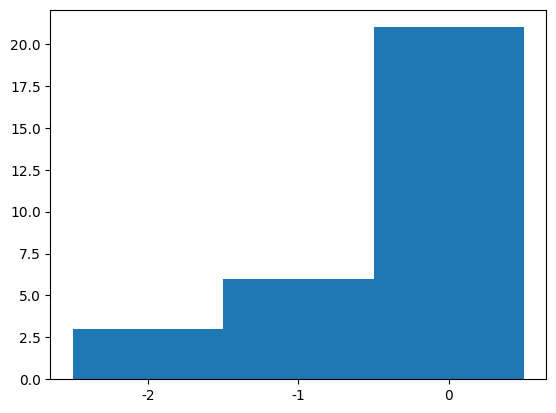

In [22]:
from matplotlib import pyplot as plt

n, bins, patches = plt.hist(pt_avg, bins=len(set(pt_avg)))
ticks = [(patch._x0 + patch._width/2) for patch in patches]
ticklabels = sorted([i for i in set(pt_avg)])
plt.xticks(ticks, ticklabels)
plt.show()

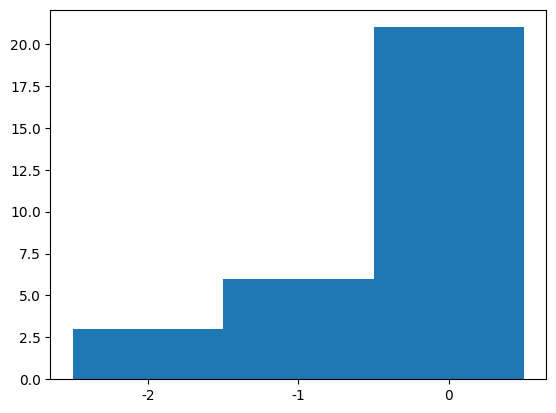

In [23]:
n, bins, patches = plt.hist(pt_max, bins=len(set(pt_max)))
ticks = [(patch._x0 + patch._width/2) for patch in patches]
ticklabels = sorted([i for i in set(pt_max)])
plt.xticks(ticks, ticklabels)
plt.show()

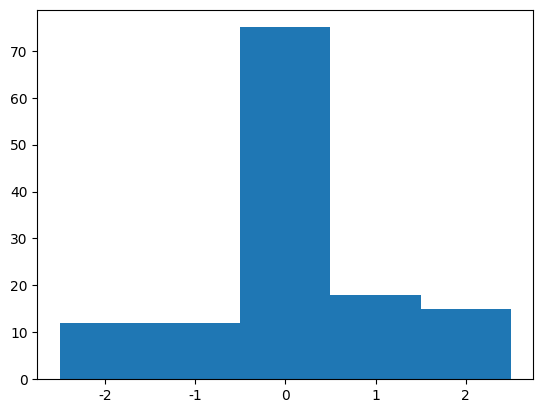

In [24]:
n, bins, patches = plt.hist(cvfs_avg, bins=len(set(cvfs_avg)))
ticks = [(patch._x0 + patch._width/2) for patch in patches]
ticklabels = sorted([i for i in set(cvfs_avg)])
plt.xticks(ticks, ticklabels)
plt.show()

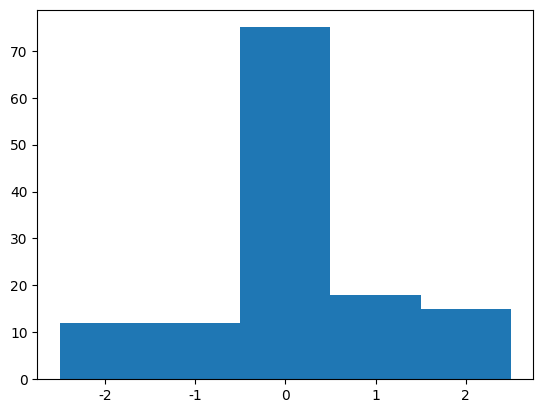

In [25]:
n, bins, patches = plt.hist(cvfs_max, bins=len(set(cvfs_max)))
ticks = [(patch._x0 + patch._width/2) for patch in patches]
ticklabels = sorted([i for i in set(cvfs_max)])
plt.xticks(ticks, ticklabels)
plt.show()

In [26]:
import csv

fieldnames = ["State", "A", "Ar", "M"]
with open(f"program_transitions_{graph_name}.csv", "w", newline="") as f:
    writer = csv.DictWriter(f, fieldnames=fieldnames)
    writer.writeheader()

    for state, rank in pt_rank_effect.items():
        writer.writerow({"State": state, **rank})

with open(f"cvf_{graph_name}.csv", "w", newline="") as f:
    writer = csv.DictWriter(f, fieldnames=fieldnames)
    writer.writeheader()

    for state, rank in cvfs_rank.items():
        writer.writerow({"State": state, **rank})


In [27]:
fieldnames = ["State", "L", "C", "A", "Ar", "M"]
with open(f"pt_rank_{graph_name}.csv", "w", newline="") as f:
    writer = csv.DictWriter(f, fieldnames=fieldnames)
    writer.writeheader()

    for state, rank in program_transitions_rank.items():
        writer.writerow({"State": state, **rank})